# KinSight
A family-focused neural network to identify my household people and paws.

This is am image classifier based on pre-trained CNN ResNet.

# 1. Dataset Format

family_dataset/
│
├── train/
│   ├── Marvin/
│   │   ├── img001.jpg
│   │   ├── img002.jpg
│   │   └── ...
│   ├── Jane/
│   ├── Eric/
│   ├── Tobin/
│   └── Wesley/
│
└── test/
    ├── Marvin/
    ├── Jane/
    ├── Eric/
    ├── Tobin/
    └── Wesley/

# Choosing this format is because:
- PyTorch’s ImageFolder class automatically reads class names from the subfolder names.
- It returns each image as a tensor and its class label as an integer.
- It avoids custom binary formats like IDX — your dataset stays human-readable and easy to extend.

# Create 30-60 images for each classes (Eric, Jane, Marvin, Tobin, Wesley)


In [43]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# batch-size 
batch_size = 2

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [42]:
# 2. Loading your dataset in PyTorch
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

training_dataset = datasets.ImageFolder(root='family_dataset/train', transform=transform)
validation_dataset  = datasets.ImageFolder(root='family_dataset/test', transform=transform)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader  = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Class labels
classes = ('Eric', 'Jane', 'Marvin', 'Tobin', 'Wesley')

# Report split sizes
print('Training set has {} instances'.format(len(training_dataset)))
print('Validation set has {} instances'.format(len(validation_dataset)))

Training set has 21 instances
Validation set has 8 instances


Marvin  Jane


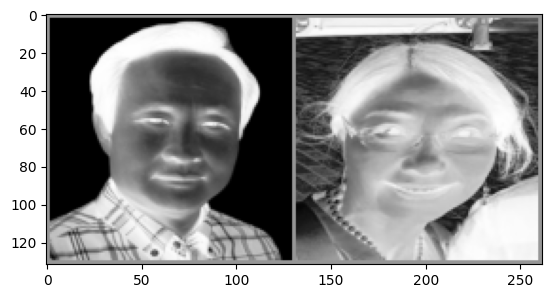

In [44]:
# let’s visualize the data as a sanity check:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(batch_size)))

In [45]:
# 3. Model choices
# We can start with a small pre-trained CNN, e.g. ResNet:
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, 5)  # 5 classes: Marvin, Jane, Eric, Tobin, Wesley

This is called transfer learning — you’re reusing a model that already knows visual features (edges, shapes, textures) and just retraining the final layer for your own categories.

In [46]:
# 4. Loss function and Optimizer

import torch.nn as nn
import torch.optim as optim

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. The Training Loop
Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

- Gets a batch of training data from the DataLoader
- Zeros the optimizer’s gradients
- Performs an inference - that is, gets predictions from the model for an input batch
- Calculates the loss for that set of predictions vs. the labels on the dataset
- Calculates the backward gradients over the learning weights
- Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
- It reports on the loss for every 1000 batches.
- Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [52]:
# A helper function that performs one training epoch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if i % 1000 == 999:
        if i % 10 == 9:
            #last_loss = running_loss / 1000 # loss per batch
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Per-Epoch Activity
There are a couple of things we’ll want to do once per epoch:

- Perform validation by checking our relative loss on a set of data that was not used for training, and report this
- Save a copy of the model

Here, we’ll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [53]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/kin_sight_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 10 loss: 0.45769192054867747
LOSS train 0.45769192054867747 valid 1.077558159828186
EPOCH 2:
  batch 10 loss: 0.278006499260664
LOSS train 0.278006499260664 valid 0.7288262844085693
EPOCH 3:
  batch 10 loss: 0.7308231312781572
LOSS train 0.7308231312781572 valid 1.0521897077560425
EPOCH 4:
  batch 10 loss: 0.20422281958162786
LOSS train 0.20422281958162786 valid 0.7659748196601868
EPOCH 5:
  batch 10 loss: 0.23290711659938096
LOSS train 0.23290711659938096 valid 0.5917090177536011


# Tensorboard 
Go to the command line to start TensorBoard, and opening it in another browser tab.
- Start tensor board:
   > tensorboard --logdir D:/dDev/AI_Computer_Vision/Projects/KinSight/runs/kin_sight_20251107_125630

- view in a browser
   https://localhost:6006

In [54]:
# 6. Evaluation

correct, total = 0, 0

model.eval()

with torch.no_grad():
    for imgs, labels in validation_loader:
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 87.50%


In [56]:
saved_model_path = "D:/dDev/AI_Computer_Vision/Projects/KinSight/model_20251107_130428_4"

saved_model = models.resnet18(weights='IMAGENET1K_V1')

saved_model.load_state_dict(torch.load(saved_model_path))

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([5, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([1000]).